# IR experimental code

In [ ]:
import math
import os
from typing import List, Tuple

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from theia.utils import display, read_positions

In [21]:
def approxContour(contour, options):
    """
    fit contour to a simpler shape
    accuracy is based on EPSILON_MULTIPLY
    """
    epsilon = options['epsilon'] * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    return approx

In [22]:
def calc_distance(p1, p2):
    """ return the distance between two points """
    return math.sqrt(((p2[0] - p1[0])**2) + ((p2[1] - p1[1])**2))


def get_contour_lengths(approx: List[List[List[int]]]) -> List[int]:
    """ 
    extract lengths from the co-ordinates 
    """
    # unnest and arrange into each corner co-ords
    # this could be done programmatically but not really worth it
    verticies = [
            [approx[0][0], approx[1][0]],
            [approx[1][0], approx[2][0]],
            [approx[2][0], approx[3][0]],
            [approx[3][0], approx[0][0]]
        ]
    lengths = list(map(lambda x: calc_distance(x[0], x[1]), verticies))
    return sorted(lengths)


def is_square(lengths, options) -> bool:
    """ check if the longest side is close in length to the shortest side """
    return ((lengths[3] - lengths[0]) / lengths[3]) < options["square_ar"]

In [23]:
def filterContours(contours, options):
    """ 
    return only the contours that are squares
    """
    squareIndexes = []

    # filter contours
    for i, contour in enumerate(contours):  # for each of the found contours
        if cv2.contourArea(contour) > options["min_area"]:
            approx = approxContour(contour, options)
            if len(approx) == 4:
                if is_square(get_contour_lengths(approx), options):
                    squareIndexes.append(i)
    
    return squareIndexes

In [24]:
def target_centre(contour: list) -> Tuple[int, int]:
    """ 
    given the square corners, return the centre of the square 
    """
    x = sum([item[0] for item in contour])/4
    y = sum([item[1] for item in contour])/4
    return int(x), int(y)

In [25]:
def find_targets(image: np.ndarray, options, debug=False) -> List[List[Tuple[int,int]]]:
    """ 
    return the centre position within the image
    """
    imgGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    imgBlurred = cv2.GaussianBlur(imgGray, (options["ksize"], options["ksize"]), options["sigma"])
    img_thresh = cv2.adaptiveThreshold(
        imgBlurred,
        255,
        cv2.ADAPTIVE_THRESH_MEAN_C, 
        cv2.THRESH_BINARY,
        options["block_size"],
        options["c"]
    )
    
    if debug: 
        display(img_thresh)

    contours, hierarchy = cv2.findContours(img_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
    squareIndexes = filterContours(contours, options)
    
    if debug:
        for index in squareIndexes:
            cv2.drawContours(image, contours[index], -1, (0, 255, 0), 3)
        display(image)

    # this for loop is mainly to check if there are multiple squares in the same image
    # otherwise there would not be a loop
    
    results = []
    for index in squareIndexes:
        target_contour = approxContour(contours[index], options)

        reshaped = target_contour.reshape(4,2)

        centre = target_centre(reshaped)

        results.append(
            centre
        )


    if len(results) == 0:
        pass

    return results

# sim_dataset testing

In [ ]:
def centre_check(predicted, actual) -> bool:
    """ True if the centre is as expected else False """
    x = math.isclose(predicted[0], actual[0], abs_tol=20)
    y = math.isclose(predicted[1], actual[1], abs_tol=20)
    return x & y

In [27]:
ref = read_positions("./dataset/target_positions")

In [28]:
image_number = 50
files = [f for f in os.listdir('./dataset/sim_dataset/')]
image = cv2.imread('./dataset/sim_dataset/' + files[image_number])
print(files[image_number])

options = {
    "block_size": 249,
    "c": -39,
    "ksize": 49,
    "sigma": 0,
    "epsilon": 0.02,
    "square_ar": 0.4,
    "min_area": 3000,
}

predicted = find_targets(image, options, debug=True)
actual = ref[files[image_number]]
print(centre_check(predicted[0], actual))
print(len(predicted) == 1)

IMG_160729_071816_0092_RGB.JPG
True
True


In [30]:
results = []
false_positives = []

for file in files:
    image = cv2.imread('./dataset/sim_dataset/' + file)
    result = find_targets(image, options, debug=False)
    try:
        result[0]
        for r in result:
            actual = ref[file]
            if centre_check(r, actual):
                results.append(1)
            else:
                results.append(0)
                false_positives.append(1)

    except:
        #result = find_targets(image, options, debug=True)
        results.append(0)

print(f"accuracy: {round(sum(results)/len(files) * 100, 2)} %")
print(f"false positives {round(sum(false_positives)/len(results) * 100, 2)} %")
print(f"no. images: {len(files)}")

accuracy: 89.02 %
false positives 1.15 %
no. images: 173


# Understanding parameter effects

In [ ]:
results = []
image = cv2.imread('./dataset/sim_dataset/' + files[image_number])

for block_size in range(29, 249, 20):
    print(block_size)
    for c in range(-100, 20, 20):
        for ksize in range(1, 9, 2):
            for sigma in [0]: #range(0, 10, 2):
                options = {
                    "block_size": block_size,
                    "c": c,
                    "ksize": ksize,
                    "sigma": sigma
                }
                result = find_targets(image, options, debug=False)
                try:
                    result[0]
                    if result[0][0] > 1080 and result[0][0] < 1100:
                        ans = 1
                    else:
                        ans = 0
                except:
                    ans = 0
                
                results.append((block_size, c, ksize, sigma, ans))

In [ ]:
df = pd.DataFrame(results)

,0,1,2,3,4
0,29,-100,1,0,0
1,29,-100,3,0,0
2,29,-100,5,0,0
3,29,-100,7,0,0
4,29,-80,1,0,0
...,...,...,...,...,...
331,289,-20,7,0,0
332,289,0,1,0,0
333,289,0,3,0,0
334,289,0,5,0,0


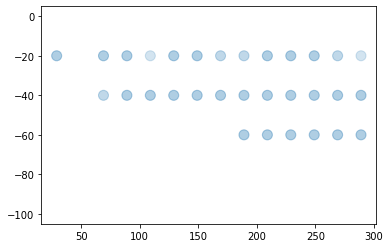

In [ ]:
plt.scatter(df[0], df[1], s=df[4]*100, alpha=0.1)

In [ ]:
df = df[df[4] == 1]

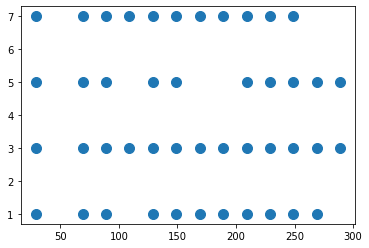

In [ ]:
df2 = df[df[1] == -20]
plt.scatter(df2[0], df2[2], s=100, alpha=1)

# Testing main IR functions

In [1]:
from theia import main
from theia import spec
import cv2
import os
from importlib import reload
reload(main)

loc = spec.LocationInfo()
image_number = 50
files = [f for f in os.listdir('./dataset/sim_dataset/')]
image = cv2.imread('./dataset/sim_dataset/' + files[image_number])
print(files[image_number])
base_dir = os.getcwd()

IMG_160729_071816_0092_RGB.JPG


In [2]:
ir = main.ImageRecognition(base_dir)
ir.image_recognition(image, loc)

2022-01-26 14:54:42,172, [INFO], main , processing image
2022-01-26 14:54:42,492, [INFO], main , ImageRecognitionResult(image_name='c:\\Users\\olive\\Documents\\GitHub\\uas-theia\\runtime\\26012022_14-54-42.240916.jpg', centre=(2310, 3193), position=(0.0, 0.0))


# Experimenting with perspective

In [18]:
ref = read_positions("./dataset/target_positions_transformed")

result = 0
files = [f for f in os.listdir('./dataset/transform_dataset/')]
for image_number in [99]: #range(len(files)):
    image = cv2.imread('./dataset/transform_dataset/' + files[image_number])
    print(files[image_number])

    options = {
        "block_size": 249,
        "c": -39,
        "ksize": 49,
        "sigma": 0,
        "epsilon": 0.02,
        "square_ar": 0.4,
        "min_area": 3000,
    }

    predicted = find_targets(image, options, debug=True)
    if len(predicted) >= 0:
        result+=1
    print(predicted)

print(result/len(files))
print(centre_check(predicted[0], (1316, 2532)))

900-900.jpg
[(1318, 2534), (3707, 288)]
0.01
True


In [33]:
options = {
    "block_size": 249,
    "c": -39,
    "ksize": 49,
    "sigma": 0,
    "epsilon": 0.02,
    "square_ar": 0.4,
    "min_area": 3000,
}
ref = read_positions("./dataset/target_positions_transformed", offset=0)
files = [f for f in os.listdir('./dataset/transform_dataset/')]
results = []
false_positives = []

for file in files:
    image = cv2.imread('./dataset/transform_dataset/' + file)
    result = find_targets(image, options, debug=False)
    try:
        result[0]
        for r in result:
            actual = ref[file]

            if centre_check(r, actual):
                results.append(1)
            else:
                results.append(0)
                false_positives.append(1)

    except Exception as e:
        results.append(0)

print(f"accuracy: {round(sum(results)/len(files) * 100, 2)} %")
print(f"false positives {round(sum(false_positives)/len(results) * 100, 2)} %")
print(f"no. images: {len(files)}")

accuracy: 80.35 %
false positives 13.55 %
no. images: 1557
